# Train-test of single PINN poisson

In [1]:
import jax.numpy as np
import numpy as onp
import optax
from jax import vmap

from base_network import neural_network
from plotutils import plot_losses, plot_poisson
from poisson.poisson_utils import boundary_loss_factory, interior_loss_factory
from utils import data_path
from xpinn import XPINN

In [2]:
file = data_path / "poisson_single_pinn_train.json"
file_test = data_path / "poisson_single_pinn_test.json"
activation = np.tanh

# Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [3]:
# Set RHS
def rhs(x):
    return np.where(
        (x[0] >= 0.25) & (x[0] <= 0.75) & (x[1] >= 0.25) & (x[1] <= 0.75), -1, 0
    )

In [4]:
# Set losses
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory(p0, 0, weight=20)
p0.interior_loss = interior_loss_factory(p0, rhs, weight=1)
p0.create_loss()
xpinn.set_loss()

In [5]:
shapes = [[2] + [20] * 7 + [1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(exponential_decay)

    pinn.init_params(shape, optimizer)

In [6]:
n_iter = 200000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 0.5497714281082153
10.00% iter = 20000 of 200000: Total loss = 0.002151667373254895
20.00% iter = 40000 of 200000: Total loss = 0.0009679304203018546
30.00% iter = 60000 of 200000: Total loss = 0.0008102606516331434
40.00% iter = 80000 of 200000: Total loss = 0.0007637516828253865
50.00% iter = 100000 of 200000: Total loss = 0.0007214476936496794
60.00% iter = 120000 of 200000: Total loss = 0.0006823872099630535
70.00% iter = 140000 of 200000: Total loss = 0.0006464421167038381
80.00% iter = 160000 of 200000: Total loss = 0.0006130633992142975
90.00% iter = 180000 of 200000: Total loss = 0.000581960950512439
100.00% iter = 200000 of 200000: Total loss = 0.0005528101464733481


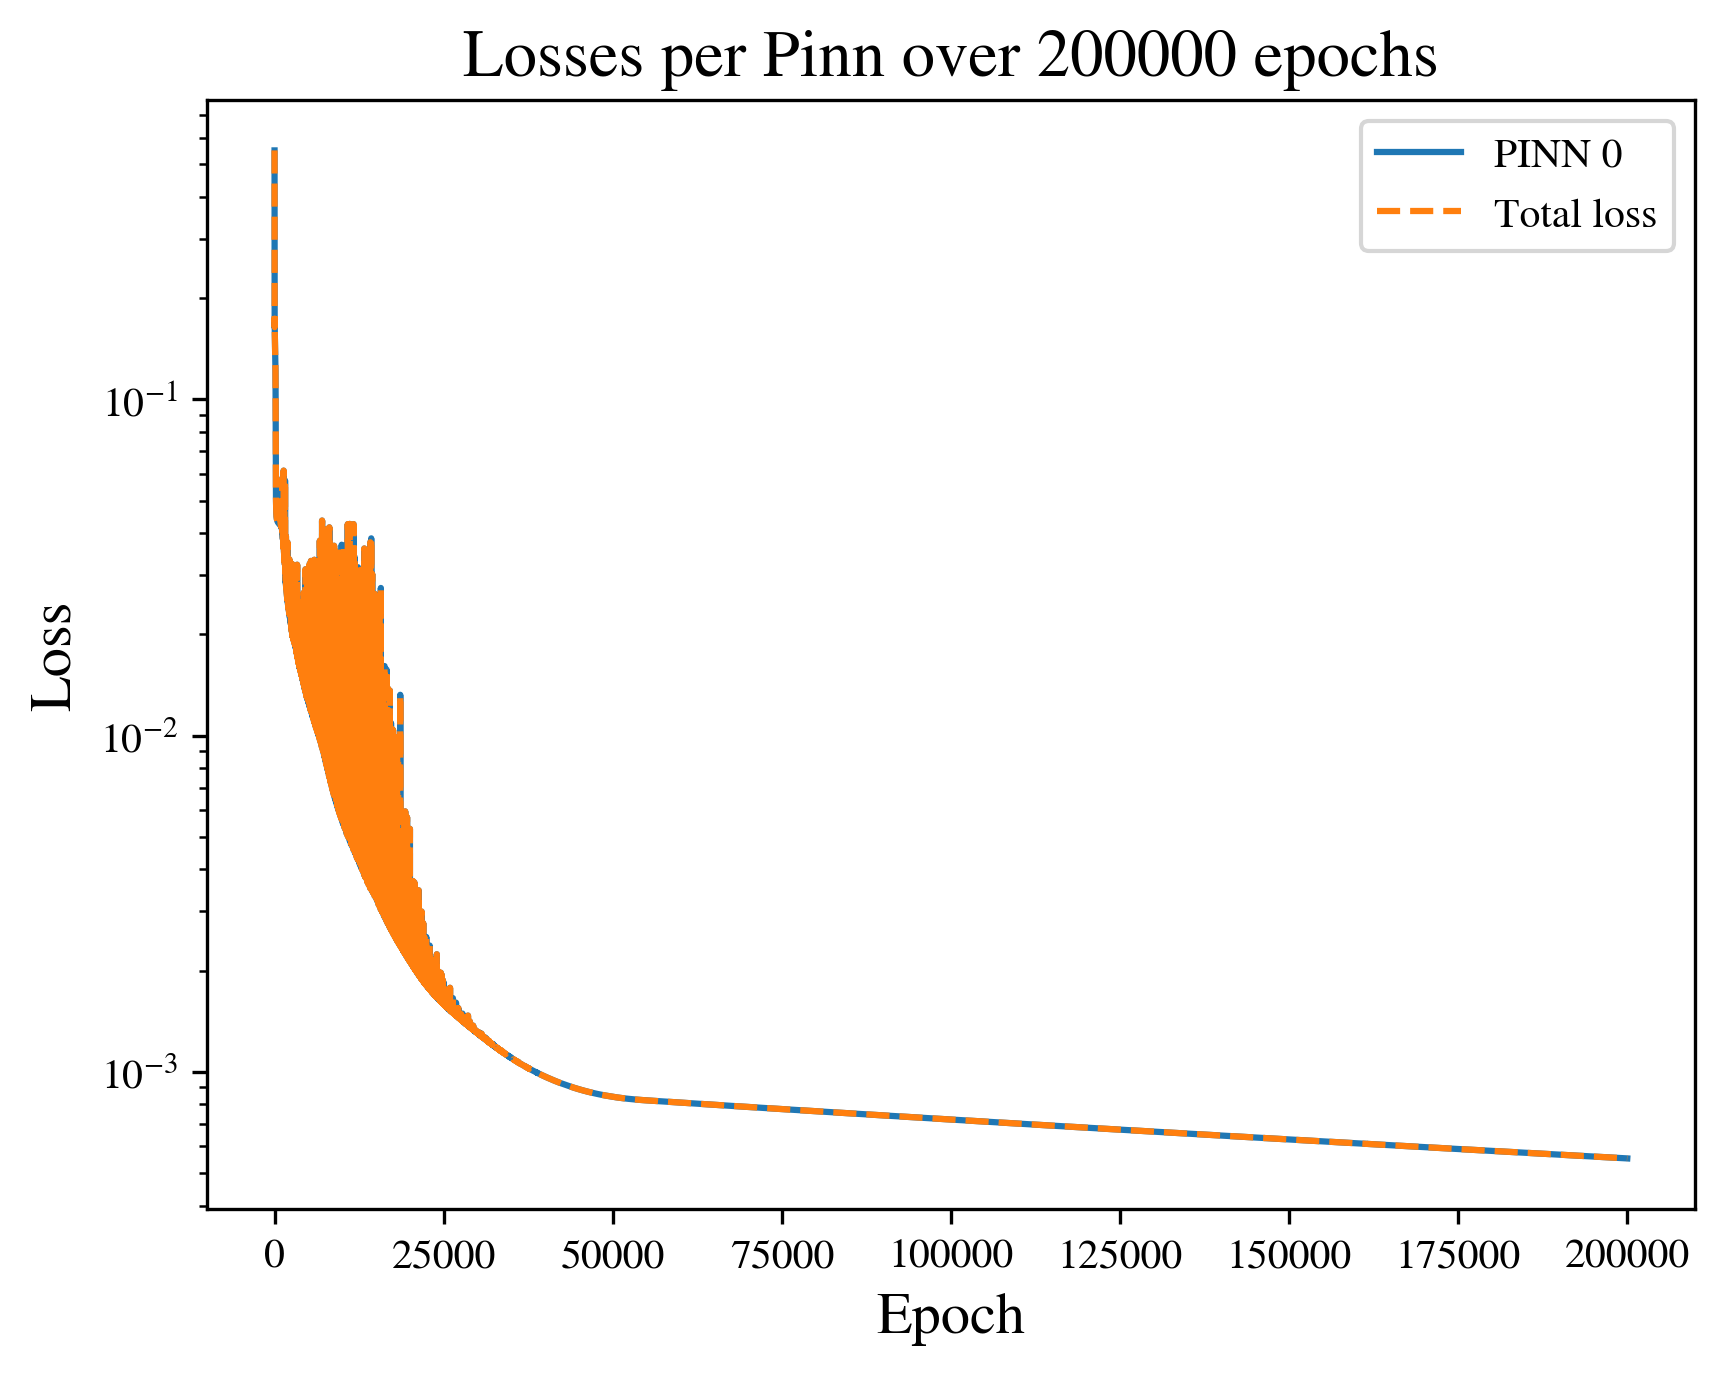

In [7]:
save_path = data_path.parent / "figures/Poisson"

plot_losses(
    losses,
    savepath=save_path,
    save_name="discrete_single_Poisson_losses.pdf",
    n_iter=n_iter,
    title=f"Losses per Pinn over {n_iter} epochs",
)

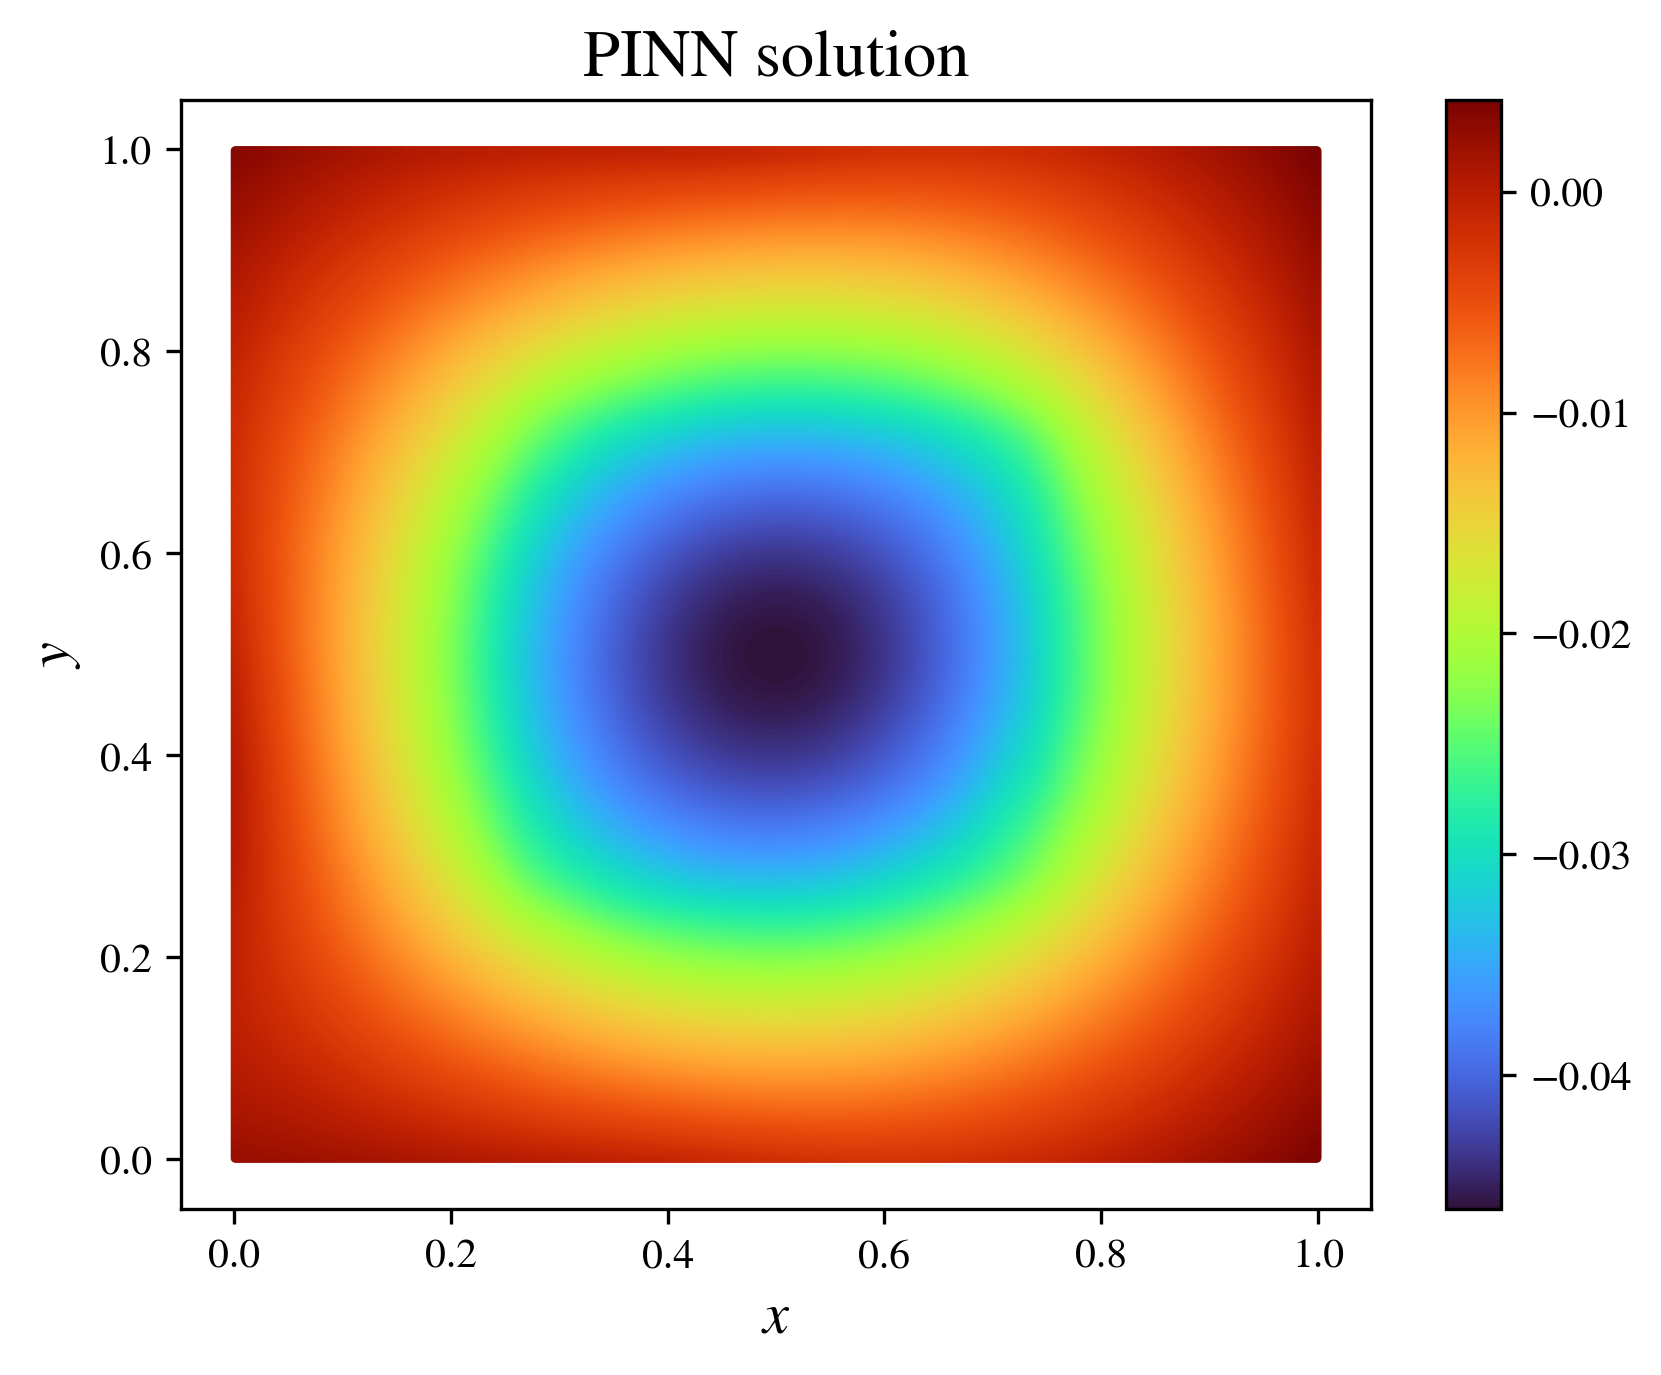

In [8]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)

plot_poisson(
    total_points,
    total_pred,
    title="PINN solution",
    savepath=save_path,
    save_name="discrete_single_Poisson_solution.pdf",
)

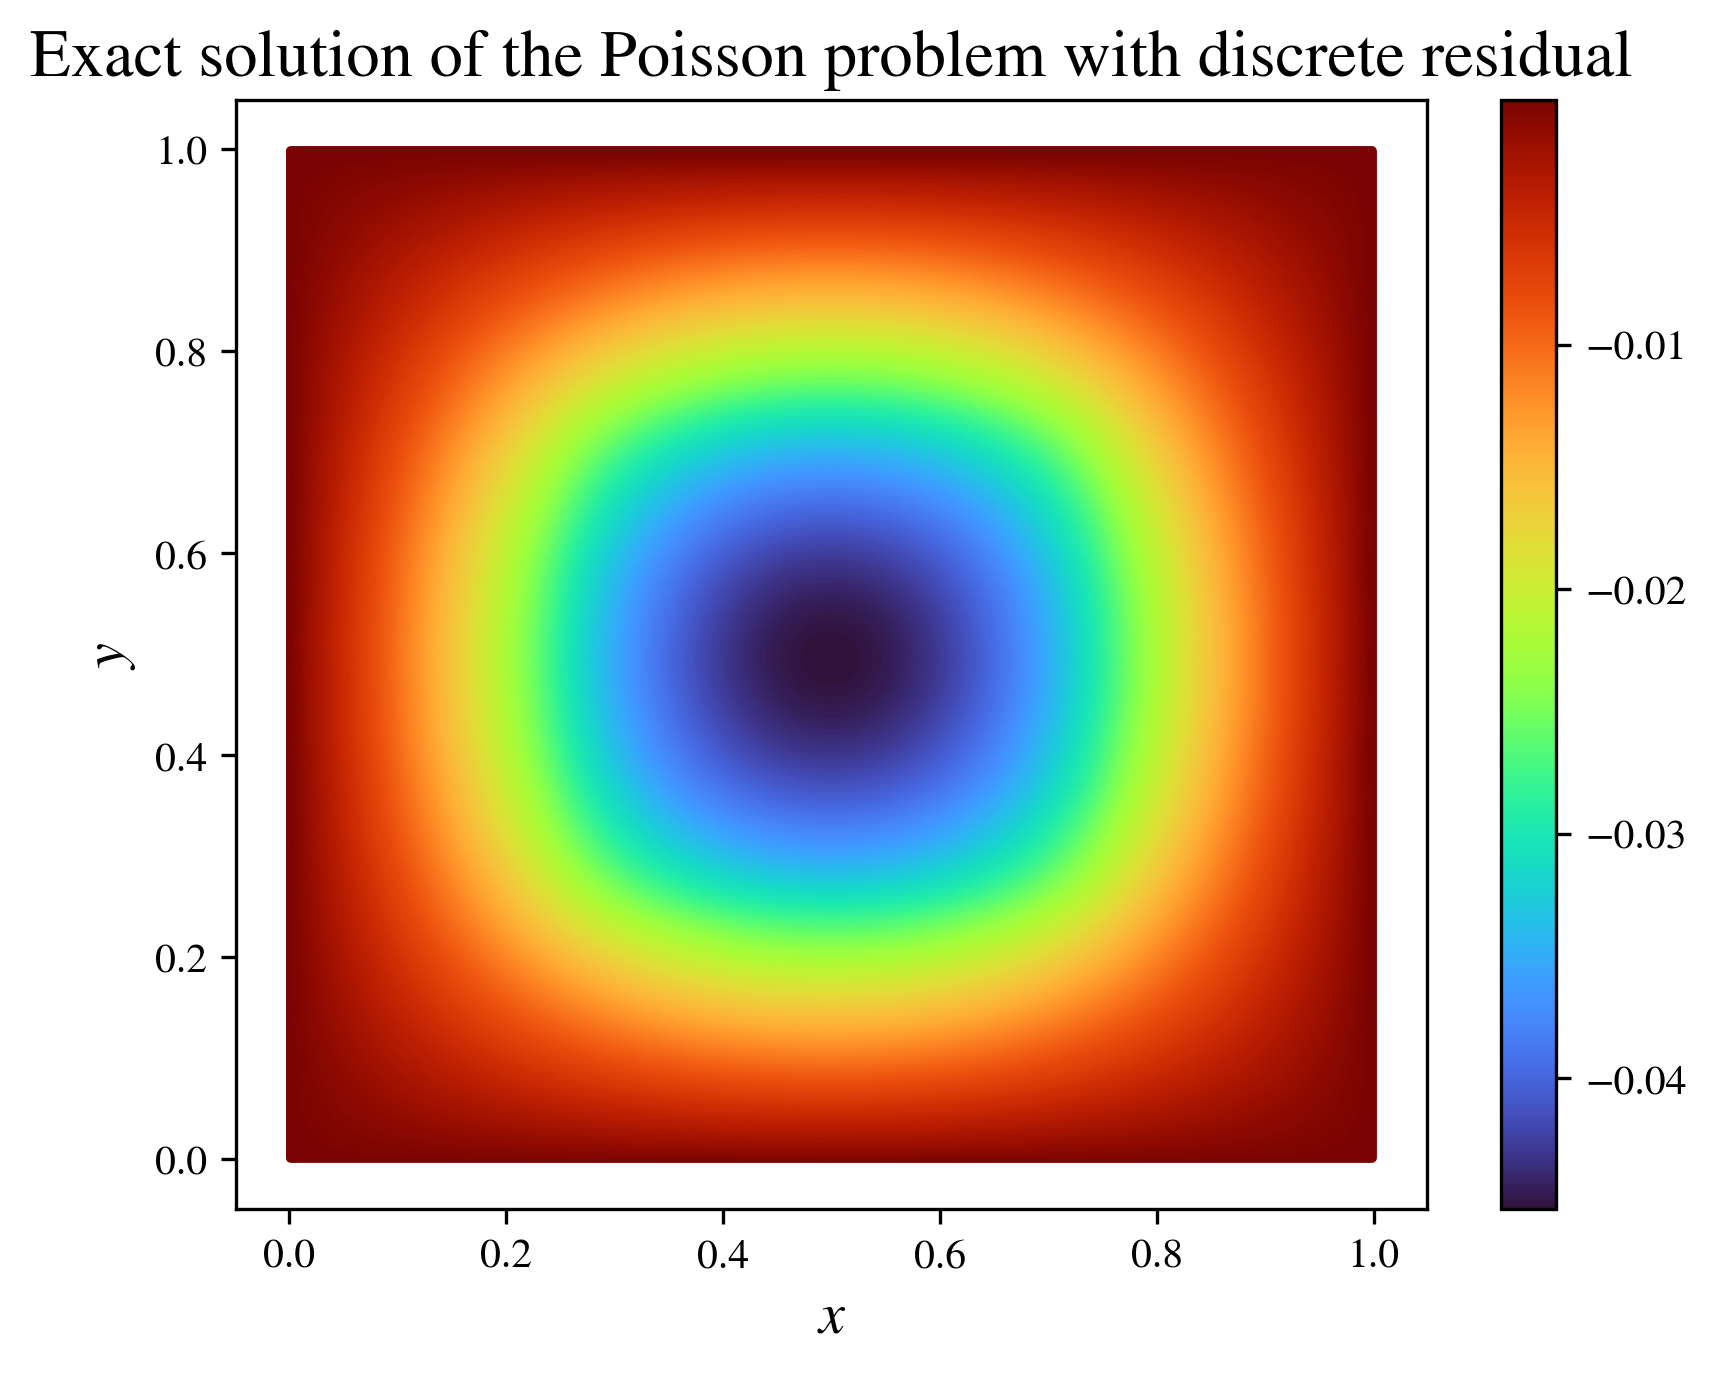

In [9]:
file = f"../true_solution.npz"
with onp.load(file) as true_file:
    true_sol = true_file["arr_0"]

plot_poisson(
    total_points,
    true_sol,
    title="Exact solution of the Poisson problem with discrete residual",
    savepath=save_path,
    save_name="discrete_Poisson_solution.pdf",
)

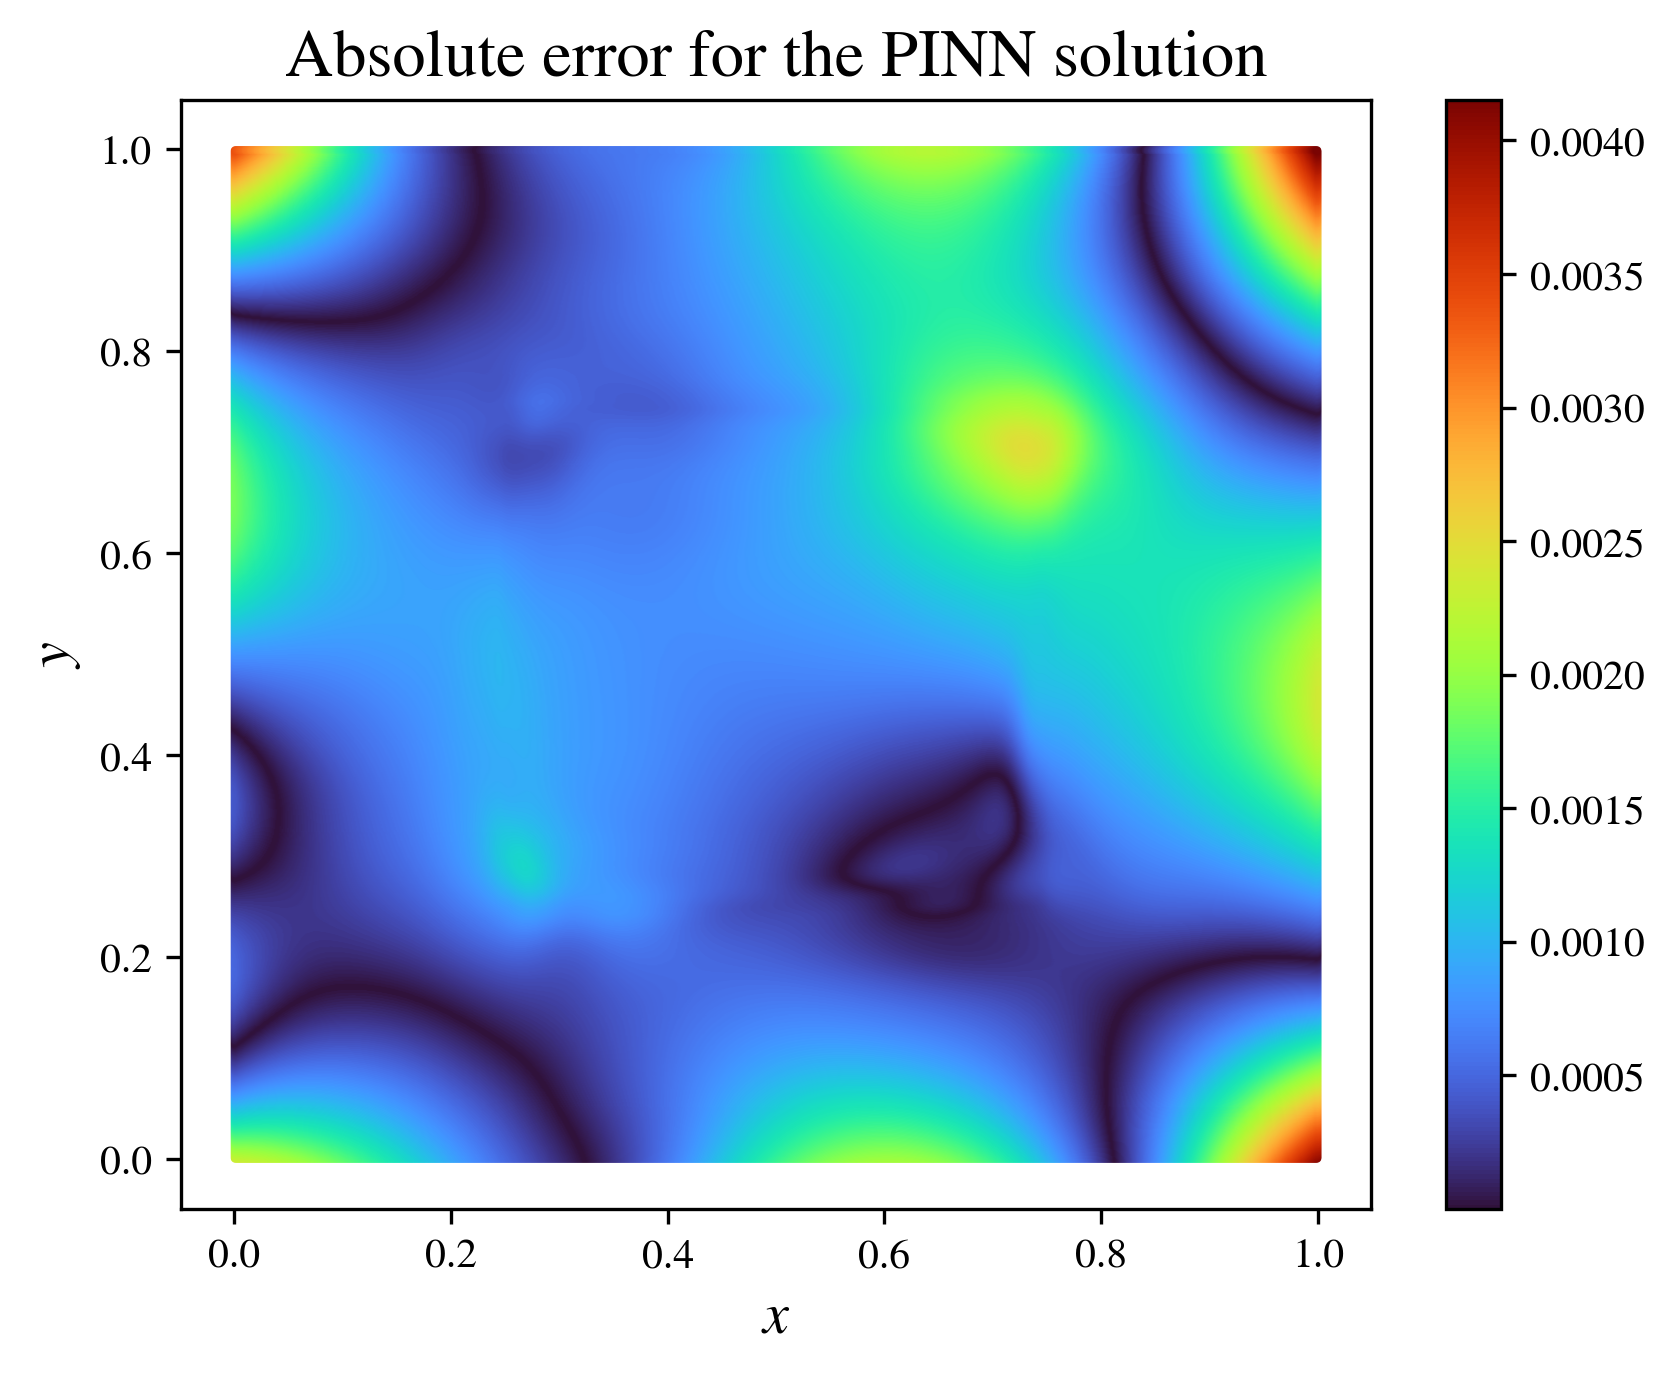

In [10]:
error = np.abs(true_sol - total_pred)

plot_poisson(
    total_points,
    error,
    title="Absolute error for the PINN solution",
    savepath=save_path,
    save_name="discrete_single_Poisson_error.pdf",
)

In [11]:
print(xpinn.PINNs[0].interior.shape)

(900, 2)
